# CP3403 Data Mining
## Report: Credit Card Fraud

### Group: Matthew Marsh, Dannielle Jones and Callum Gracie

This data mining explores: A time series to see if there is a relationship between the number of fraud cases over time.

# Import Packages and Get Data

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from math import sqrt

In [41]:
data = pd.read_csv('../data/fraudTrain.csv')  # Read

In [42]:
print('Dataset rows: {} columns: {}'.format(data.shape[0], data.shape[1]))
data.head()

Dataset rows: 1296675 columns: 23


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


# Pre-Processing: NaN Data and Missing Data

In [43]:
# Check dataset for missing or NaN values
print('Dataset rows: {} columns: {}'.format(data.shape[0], data.shape[1]))
missing_values_count = data.isna().sum()
print(missing_values_count)

Dataset rows: 1296675 columns: 23
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


# Pre-Processing: Convert and Format Data

In [44]:
# View the unnamed column, then get and rename
print(data.iloc[:,0])
data = data.rename(columns={data.columns[0]: "column_id"})
data.set_index('column_id', inplace=True)
data.head()

0                0
1                1
2                2
3                3
4                4
            ...   
1296670    1296670
1296671    1296671
1296672    1296672
1296673    1296673
1296674    1296674
Name: Unnamed: 0, Length: 1296675, dtype: int64


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
column_id,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [45]:
# Convert to numeric
data['amt'] = pd.to_numeric(data['amt'], errors='coerce')
data['zip'] = pd.to_numeric(data['zip'], errors='coerce')
data['lat'] = pd.to_numeric(data['lat'], errors='coerce')
data['long'] = pd.to_numeric(data['long'], errors='coerce')
data['city_pop'] = pd.to_numeric(data['city_pop'], errors='coerce')
data['merch_lat'] = pd.to_numeric(data['merch_long'], errors='coerce')
data['is_fraud'] = pd.to_numeric(data['is_fraud'], errors='coerce')

In [46]:
# Processing date of birth
data['dob'] = pd.to_datetime(data['dob'])  # convert to datetime object
data['year_of_birth'] = data['dob'].dt.year  # extract year
data['month_of_birth'] = data['dob'].dt.month  # extract month
data['day_of_birth'] = data['dob'].dt.day  # extract day
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,year_of_birth,month_of_birth,day_of_birth
column_id,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,-82.048315,-82.048315,0,1988,3,9
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,-118.186462,-118.186462,0,1978,6,21
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,-112.154481,-112.154481,0,1962,1,19
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,-112.561071,-112.561071,0,1967,1,12
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,-78.632459,-78.632459,0,1986,3,28


In [47]:
# Processing transaction date and time
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])  # convert to datetime object
data['trans_year'] = data['trans_date_trans_time'].dt.year  # extract year
data['trans_month'] = data['trans_date_trans_time'].dt.month  # extract month
data['trans_day'] = data['trans_date_trans_time'].dt.day  # extract day
data['trans_time'] = data['trans_date_trans_time'].dt.time  # extract time
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,merch_lat,merch_long,is_fraud,year_of_birth,month_of_birth,day_of_birth,trans_year,trans_month,trans_day,trans_time
column_id,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-82.048315,-82.048315,0,1988,3,9,2019,1,1,00:00:18
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.186462,-118.186462,0,1978,6,21,2019,1,1,00:00:44
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.154481,-112.154481,0,1962,1,19,2019,1,1,00:00:51
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.561071,-112.561071,0,1967,1,12,2019,1,1,00:01:16
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-78.632459,-78.632459,0,1986,3,28,2019,1,1,00:03:06


In [48]:
# Processing Gender into binary
gender_count = data['gender'].value_counts()
data['is_female'] = data['gender'].apply(lambda x: 1 if x.upper() == "F" else 0)
is_female_count = data['is_female'].value_counts()
print("Gender Count: \n{}".format(gender_count))
print("is_female Count: \n{}".format(is_female_count))
data.head()

Gender Count: 
F    709863
M    586812
Name: gender, dtype: int64
is_female Count: 
1    709863
0    586812
Name: is_female, dtype: int64


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,merch_long,is_fraud,year_of_birth,month_of_birth,day_of_birth,trans_year,trans_month,trans_day,trans_time,is_female
column_id,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-82.048315,0,1988,3,9,2019,1,1,00:00:18,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.186462,0,1978,6,21,2019,1,1,00:00:44,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.154481,0,1962,1,19,2019,1,1,00:00:51,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.561071,0,1967,1,12,2019,1,1,00:01:16,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-78.632459,0,1986,3,28,2019,1,1,00:03:06,0


In [49]:
sub1 = data.copy()

# Pre-Processing: Create Data Sub-Set

In [50]:
# Reduce sample size for computation: Get random sub-sample
np.random.seed(42)
sub_size = 500

fraud_cases = sub1[sub1['is_fraud'] == 1]
non_fraud_cases = sub1[sub1['is_fraud'] != 1]

fraud_subsample = fraud_cases.sample(n=sub_size // 2, random_state=42)
non_fraud_subsample = non_fraud_cases.sample(n=sub_size // 2, random_state=42)

sub1 = pd.concat([fraud_subsample, non_fraud_subsample])
sub1 = sub1.sample(frac=1, random_state=42)

print('Subset rows: {} columns: {}'.format(sub1.shape[0], sub1.shape[1]))
sub1.head()

Subset rows: 500 columns: 30


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,merch_long,is_fraud,year_of_birth,month_of_birth,day_of_birth,trans_year,trans_month,trans_day,trans_time,is_female
column_id,,,,,,,,,,,,,,,,,,,,,
532607,2019-08-17 13:12:59,3533742182628021,fraud_Lynch Ltd,shopping_pos,2.72,Robert,Haynes,M,857 Aaron Circles Suite 398,Johns Island,...,-80.594768,0,1997,6,4,2019,8,17,13:12:59,0
1232178,2020-05-29 15:12:38,6515067575568369,fraud_Kerluke-Abshire,shopping_net,919.37,Kevin,Pena,M,2674 Bentley Radial,Damascus,...,-82.410783,1,1990,10,15,2020,5,29,15:12:38,0
1252631,2020-06-05 19:00:30,4266200684857219,fraud_Johnston-Casper,travel,1.06,Joshua,Bryant,M,5452 Patricia Inlet Apt. 280,Nelson,...,-98.823706,0,1956,12,13,2020,6,5,19:00:30,0
51239,2019-01-30 22:59:20,4155021259183870,fraud_Prosacco LLC,personal_care,19.69,Renee,Parrish,F,174 Jennifer Meadow Apt. 467,Mountain Park,...,-99.867127,1,1983,10,12,2019,1,30,22:59:20,1
737710,2019-11-11 07:19:40,4390966588600992777,"fraud_Heller, Gutmann and Zieme",grocery_pos,294.87,Kyle,Simmons,M,8149 Harris Divide,Oklahoma City,...,-98.053195,1,1966,6,24,2019,11,11,07:19:40,0


In [51]:
# Check how many cases are fraud
is_fraud_count = sub1[(sub1['is_fraud'] == 1)]
print('Fraud count: {}'.format(len(is_fraud_count)))
is_not_fraud_count = sub1[(sub1['is_fraud'] != 1)]
print('Non-Fraud count: {}'.format(len(is_not_fraud_count)))
is_fraud_count.head()

Fraud count: 250
Non-Fraud count: 250


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,merch_long,is_fraud,year_of_birth,month_of_birth,day_of_birth,trans_year,trans_month,trans_day,trans_time,is_female
column_id,,,,,,,,,,,,,,,,,,,,,
1232178,2020-05-29 15:12:38,6515067575568369,fraud_Kerluke-Abshire,shopping_net,919.37,Kevin,Pena,M,2674 Bentley Radial,Damascus,...,-82.410783,1,1990,10,15,2020,5,29,15:12:38,0
51239,2019-01-30 22:59:20,4155021259183870,fraud_Prosacco LLC,personal_care,19.69,Renee,Parrish,F,174 Jennifer Meadow Apt. 467,Mountain Park,...,-99.867127,1,1983,10,12,2019,1,30,22:59:20,1
737710,2019-11-11 07:19:40,4390966588600992777,"fraud_Heller, Gutmann and Zieme",grocery_pos,294.87,Kyle,Simmons,M,8149 Harris Divide,Oklahoma City,...,-98.053195,1,1966,6,24,2019,11,11,07:19:40,0
455456,2019-07-21 03:24:29,3552581383553463,"fraud_Lind, Huel and McClure",gas_transport,9.46,Jonathan,Castro,M,200 Christie Mills Apt. 307,Andrews,...,-84.040263,1,1965,4,13,2019,7,21,03:24:29,0
64639,2019-02-07 23:44:47,577891228931,fraud_Kerluke-Abshire,shopping_net,1096.03,Lisa,Carpenter,F,48437 English Ways Suite 579,La Grande,...,-118.697593,1,1961,6,16,2019,2,7,23:44:47,1


In [52]:
sub2 = sub1.copy()

# Data Mining Technique/Method: Time Series
## Visualisation: Pre-Processing

In [53]:
# Set date/time as index and sub-sample relevant columns
sub2['trans_date'] = sub2['trans_date_trans_time'].dt.date  # extract date
sub2['trans_date'] = pd.to_datetime((sub2['trans_date']))
sub2.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_fraud,year_of_birth,month_of_birth,day_of_birth,trans_year,trans_month,trans_day,trans_time,is_female,trans_date
column_id,,,,,,,,,,,,,,,,,,,,,
532607,2019-08-17 13:12:59,3533742182628021,fraud_Lynch Ltd,shopping_pos,2.72,Robert,Haynes,M,857 Aaron Circles Suite 398,Johns Island,...,0,1997,6,4,2019,8,17,13:12:59,0,2019-08-17
1232178,2020-05-29 15:12:38,6515067575568369,fraud_Kerluke-Abshire,shopping_net,919.37,Kevin,Pena,M,2674 Bentley Radial,Damascus,...,1,1990,10,15,2020,5,29,15:12:38,0,2020-05-29


In [54]:
sub2 = sub2[['trans_date', 'is_fraud']].copy()
sub2['trans_date'] = pd.to_datetime(sub2['trans_date']).dt.to_period('M').dt.to_timestamp()
sub2 = sub2.sort_values(by='trans_date')
sub2.head()

,trans_date,is_fraud
column_id,,
31628,2019-01-01,1
32458,2019-01-01,1
12338,2019-01-01,1
41927,2019-01-01,1
21688,2019-01-01,1


In [55]:
fraud_count_group = sub2[sub2['is_fraud'] == 1].groupby('trans_date').sum()
print(f"Count: {len(fraud_count_group)}")
fraud_count_group.rename(columns={'is_fraud': 'fraud_count'}, inplace=True)
fraud_count_group.head()

Count: 18


,fraud_count
trans_date,
2019-01-01,18
2019-02-01,17
2019-03-01,23
2019-04-01,13
2019-05-01,18


In [56]:
sub2 = fraud_count_group
sub2.head(2)

,fraud_count
trans_date,
2019-01-01,18
2019-02-01,17


In [57]:
sub2.head(1)  # View start date

,fraud_count
trans_date,
2019-01-01,18


In [58]:
sub2.tail(1)  # View end date

,fraud_count
trans_date,
2020-06-01,12


In [59]:
# Slice specific time frame
date_range_from = '2019-01-01'
date_range_to = '2020-01-01'

sub2 = sub2[date_range_from:date_range_to]

transaction_all_data = sub2.copy()  # All dates
transaction_all_data.head()

,fraud_count
trans_date,
2019-01-01,18
2019-02-01,17
2019-03-01,23
2019-04-01,13
2019-05-01,18


## Visualisation: Plots/Graphs

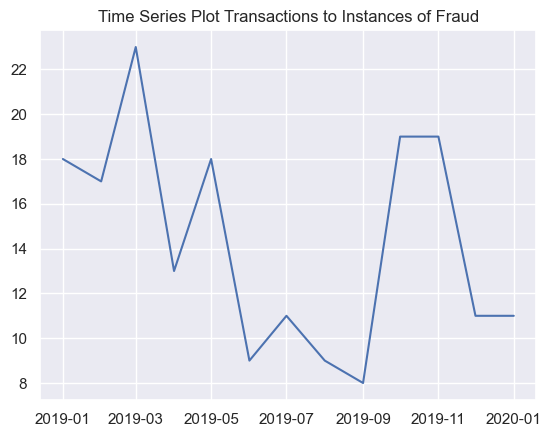

In [60]:
%matplotlib inline

# Plot of transaction data - all
plt.title("Time Series Plot Transactions to Instances of Fraud")
plt.plot(transaction_all_data['fraud_count'])

### Stationary Check

In [61]:
# Perform Stationary Test
def test_stationary(timeseries, number_of_months):

    #Determing rolling statistics
    rolling_mean = timeseries.rolling(window=number_of_months).mean()
    rolling_std = timeseries.rolling(window=number_of_months).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

Stationary Test - ALl Data


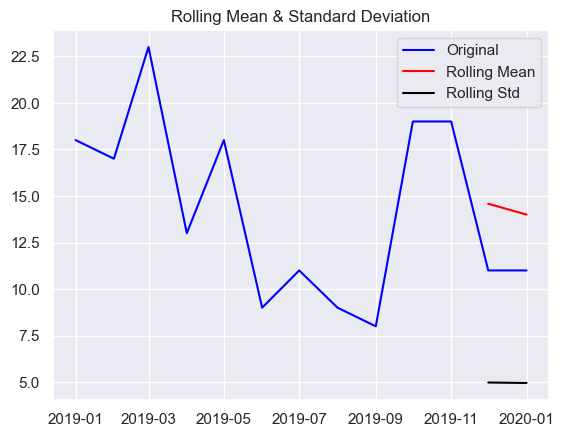

In [62]:
print("Stationary Test - ALl Data")
test_stationary(transaction_all_data['fraud_count'], 12)
print()

In [63]:
# Perform Dickey-Fuller Test
def test_dickey_fuller(timeseries):
    print('Results of Dickey-Fuller Test:')
    df_test = adfuller(timeseries, autolag='AIC')

    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print (df_output)

In [64]:
print("Dickey Fuller Test - ALl Data")
test_dickey_fuller(transaction_all_data['fraud_count'])
print()

Dickey Fuller Test - ALl Data
Results of Dickey-Fuller Test:
Test Statistic                 -2.592364
p-value                         0.094586
#Lags Used                      0.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64



#### Conclusions:
The p-value > 0.05 indicates that we cannot reject the null hypothesis that it is non-stationary.

### Auto-correlation

In [65]:
# Perform auto-correlation lag
def auto_correlation_lag(dataframe, column_name, number_of_months):
    """
    Perform auto correlation lag
    :param dataframe:
    :param column_name:
    :param number_of_months:
    :return: auto lag correlation by number of months
    """
    return dataframe[column_name].autocorr(lag=number_of_months)

In [66]:
lag_month_number = 1

print(f"All Data - {lag_month_number} Month Lag: {auto_correlation_lag(transaction_all_data, 'fraud_count', lag_month_number)}")

lag_month_number = 3
print(f"All Data - {lag_month_number} Month Lag: {auto_correlation_lag(transaction_all_data, 'fraud_count', lag_month_number)}")

All Data - 1 Month Lag: 0.20261228679836377
All Data - 3 Month Lag: -0.27559731548349015


#### Conclusions:
For one month: There is a weak positive correlation between the current month with the next month.
For three month: There is a weak negative correlation between the current quarter and the prior quarter.

### Decomposition

In [67]:
# Get log to make patterns or trends more apparent
def get_log(dataframe, column_name):
    """
    Find log by dataframe and column name
    :param dataframe:
    :param column_name:
    :return: log
    """
    return np.log(dataframe[column_name])

In [68]:
ts_log_all = get_log(transaction_all_data, 'fraud_count')

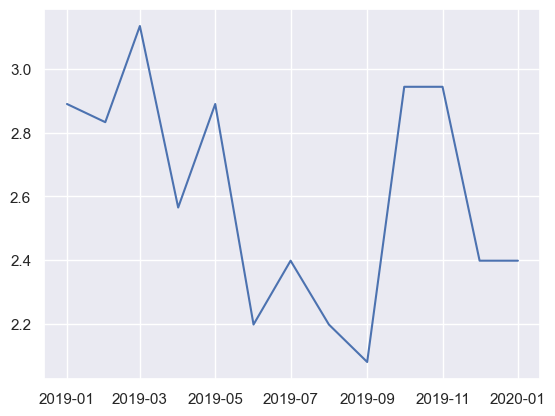

In [69]:
plt.plot(ts_log_all)

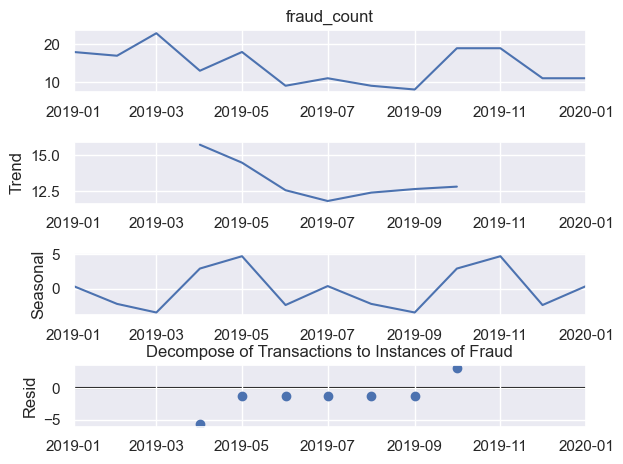

In [70]:
decompose_all = seasonal_decompose(transaction_all_data['fraud_count'], model='additive', period=6)
decompose_all.plot()
plt.title("Decompose of Transactions to Instances of Fraud")
plt.show()

#### Conclusion:
There is very little trend seen in any of the data.

### Forecasting

In [71]:
# Split into train and test data
train = transaction_all_data['2019-01-01':'2019-06-01'].copy()
train['train'] = train['fraud_count']
train = train[['train']]

test = transaction_all_data['2019-06-01':'2020-01-01'].copy()
test['train'] = test['fraud_count']
test = test[['train']]

In [72]:
train.head()

,train
trans_date,
2019-01-01,18
2019-02-01,17
2019-03-01,23
2019-04-01,13
2019-05-01,18


In [73]:
test.head()

,train
trans_date,
2019-06-01,9
2019-07-01,11
2019-08-01,9
2019-09-01,8
2019-10-01,19


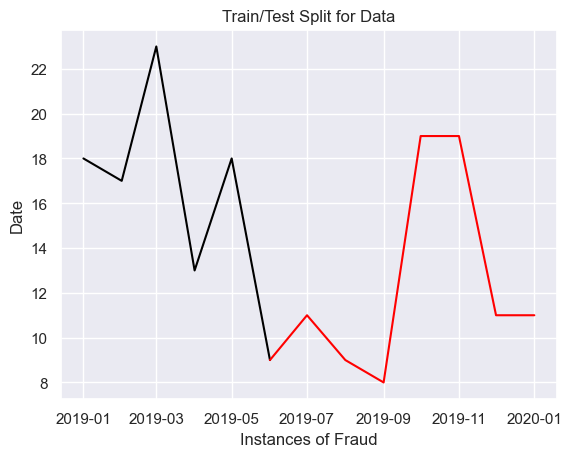

In [74]:
# Plot the training and test data prediction
plt.plot(train, color='black')
plt.plot(test, color='red')
plt.title('Train/Test Split for Data')
plt.xlabel('Instances of Fraud')
plt.ylabel('Date')
sns.set()
plt.show()

In [75]:
# Construct ARIMA model
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=40.600, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=38.764, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=39.825, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=52.963, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.192 seconds


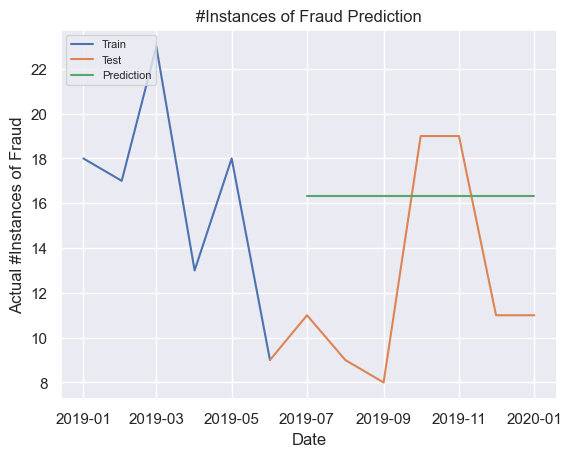

In [76]:
# Display model
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.title('#Instances of Fraud Prediction')
plt.xlabel('Date')
plt.ylabel('Actual #Instances of Fraud')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [77]:
# Calculate root mean squared error
test = test.dropna()
forecast = forecast.dropna()
print("Length of test:", len(test))
print("Length of forecast:", len(forecast))

Length of test: 8
Length of forecast: 7


In [78]:
# rmse = sqrt(mean_squared_error(test, forecast))
# print("RMSE: ", rmse)

## Discussion: Visualisation: Results and Data
Time series has not been useful to identify patterns regarding how many fraud cases will occur over time.